# Homework: 02-Regression

[ML zoomcamp](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp/01-intro) course.  
[Homework](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/01-intro/homework.md)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# ! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

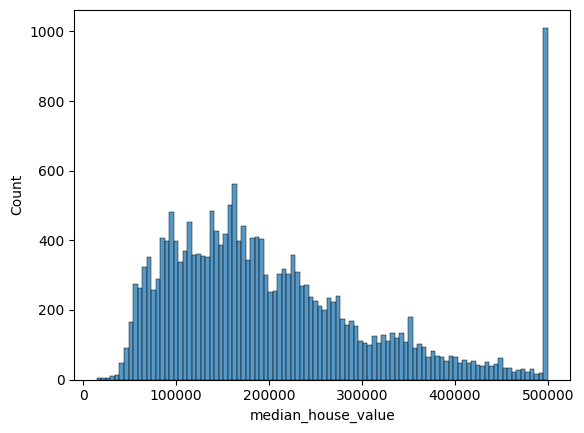

In [3]:
sns.histplot(df.median_house_value, bins = 100)

In [4]:
del df['ocean_proximity']
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Q1: Find a feature with missing values. How many missing values does it have?

In [5]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Q2: What's the median (50% percentile) for variable 'population'?

In [6]:
print(df.population.median())
df.population.describe()

1166.0


count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

In [7]:
#  60-20-20% split

def split_data(df, seed = 42):
    
    '''
    Splits 60-20-20 and returns X = (x_train, x_val, x_test) and y = (y_train, y_val, y_test)
    '''
    
    df = df.copy()

    df = df.sample(frac=1, random_state = seed)

    y = df['median_house_value']
    y = np.log1p(y)
    del df['median_house_value']

    idx1, idx2 = int(0.6*len(df)), int(0.8*len(df))
    X = np.split(df, [idx1, idx2])
    y = np.split(y, [idx1, idx2])
    
    return X, y

(<AxesSubplot: xlabel='median_house_value', ylabel='Count'>,
 <AxesSubplot: xlabel='median_house_value', ylabel='Count'>)

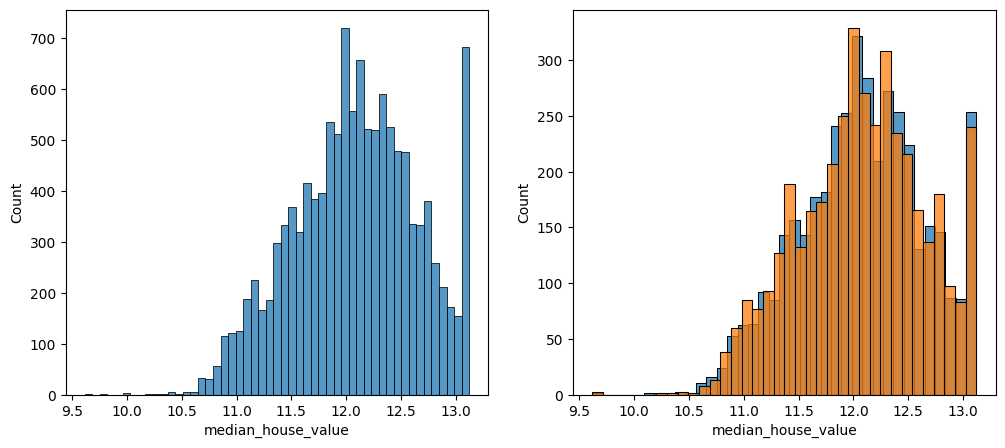

In [8]:
# train, val and test sets are from same distributions
# so we can train the model

_, (y_train, y_val, y_test) = split_data(df)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 5)
sns.histplot(y_train, ax=ax[0])
sns.histplot(y_test, ax=ax[1]), sns.histplot(y_val,ax=ax[1])

## Q4: replace missing values
We can fill in with 0 (thus ignoring the feature in LR) or with median values. Let's find out which one is 'better'

In [9]:
# fill with 0s
(x_train, x_val, x_test), (y_train, y_val, y_test) = split_data(df.fillna(0))

linreg = LinearRegression().fit(x_train, y_train)

# eval on training set
y_pred = linreg.predict(x_train)
print(mean_squared_error(y_pred, y_train, squared=False))

# eval on validation set
y_pred = linreg.predict(x_val)
print(round(mean_squared_error(y_pred, y_val, squared=False),10))

0.34131359101566766
0.3295330365


In [10]:
# fill with mean values
(x_train, x_val, x_test), (y_train, y_val, y_test) = split_data(df)
replace_by = x_train.total_bedrooms.mean()
(x_train, x_val, x_test), (y_train, y_val, y_test) = split_data(df.fillna(replace_by))


linreg = LinearRegression().fit(x_train, y_train)

# eval on training set
y_pred = linreg.predict(x_train)
print(mean_squared_error(y_pred, y_train, squared=False))

# eval on validation set
y_pred = linreg.predict(x_val)
print(round(mean_squared_error(y_pred, y_val, squared=False),10))


0.34104161810328054
0.3290195439


## Q5: regularize and choose optimal value of r
Note: adding a small number $r$ to the diagonal elements of $X^T X$ matrix is essentially the same as adding term $r\sum w_j^2$ to the loss function

In [11]:
(x_train, x_val, x_test), (y_train, y_val, y_test) = split_data(df.fillna(0))

for alpha in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    
    reg = Ridge(alpha=alpha).fit(x_train, y_train)
    print('r =', alpha)
    
    # eval on validation set
    y_pred = linreg.predict(x_test)
    print('rmse val:', round(mean_squared_error(y_pred, y_test, squared=False), 2))
    
    print()

r = 0
rmse val: 0.35

r = 1e-06
rmse val: 0.35

r = 0.0001
rmse val: 0.35

r = 0.001
rmse val: 0.35

r = 0.01
rmse val: 0.35

r = 0.1
rmse val: 0.35

r = 1
rmse val: 0.35

r = 5
rmse val: 0.35

r = 10
rmse val: 0.35



Sklearn implementation worked better then a direct inversion. It seems that better algorithms are used (like [scipy.optimize.nnls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html) and [scipy.linalg.lstsq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html)

To answer the questions let's use the course [notebook](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-02-car-price/02-carprice.ipynb).

In [12]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
(x_train, x_val, x_test), (y_train, y_val, y_test) = split_data(df.fillna(0))
x_train = x_train.to_numpy()

for alpha in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    print(alpha)
    w_0, w = train_linear_regression_reg(x_train, y_train, r=alpha)

    y_pred = w_0 + x_val.dot(w)
    print('val:', round(mean_squared_error(y_pred, y_val, squared=False),2))
    print()

0
val: 0.33

1e-06
val: 0.33

0.0001
val: 0.33

0.001
val: 0.33

0.01
val: 0.33

0.1
val: 0.33

1
val: 0.33

5
val: 0.34

10
val: 0.34



## Q5: evaluate the LR model for different seed values and find the std of rmse.

In [14]:
rmse = []
for seed in range(10):
    (x_train, x_val, x_test), (y_train, y_val, y_test) = split_data(df.fillna(0), seed=seed)

    linreg = LinearRegression().fit(x_train, y_train)

    # eval on validation set
    y_pred = linreg.predict(x_val)
    rmse.append(mean_squared_error(y_pred, y_val, squared=False))

In [15]:
print(rmse)
round(np.std(rmse), 3)

[0.33884304805305293, 0.3362387255956413, 0.3320912318834922, 0.3405153609035668, 0.33890240665724547, 0.3434866725718445, 0.3451980953099276, 0.33959899274092836, 0.34662308731842484, 0.3365926124180074]


0.004

## Q6: evaluate on the test set
seed=9 

In [16]:
#  80-20% split

def split_data(df, seed = 9):
    
    '''
    Splits 80-20 and returns X = (x_train, x_test) and y = (y_train, y_test)
    '''
    
    df = df.copy()

    df = df.sample(frac=1, random_state = seed)

    y = df['median_house_value']
    y = np.log1p(y)
    del df['median_house_value']

    idx1 = int(0.8*len(df))
    X = np.split(df, [idx1])
    y = np.split(y, [idx1])
    
    return X, y

In [17]:
(x_train, x_test), (y_train, y_test) = split_data(df.fillna(0))

linreg = LinearRegression().fit(x_train, y_train)

# eval on test set
y_pred = linreg.predict(x_test)
mean_squared_error(y_pred, y_test, squared=False)

0.3453149507171797